In [1]:
import numpy as np
import cv2
import tensorflow as tf

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
!pip install opencv_jupyter_ui

In [3]:
from opencv_jupyter_ui import cv2_imshow

ModuleNotFoundError: No module named 'opencv_jupyter_ui'

In [4]:
face_detection_model = cv2.dnn.readNetFromCaffe('./models/deploy.prototxt.txt',
                                              './models/res10_300x300_ssd_iter_140000_fp16.caffemodel')
model = tf.keras.models.load_model('face_cnn_model/')

Metal device set to: Apple M1


2022-05-17 17:11:31.804840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-17 17:11:31.805101: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
labels = ['Mask', 'No Mask', 'Covered Mouth Chin', 'Covered Nose Mouth']

def getcolor(labels):
    if labels == "Mask":
        color = (0,255,0)
        
    elif labels == "No Mask":
        color = (0,0,255)
        
    elif labels == "Covered Mouth Chin":
        color = (0,255,255)    
        
        
    else:
        color = (255,255,0)    
        
    return color    

In [6]:
getcolor("Mask")

(0, 255, 0)

In [7]:
import matplotlib.pyplot as plt

In [8]:
from scipy.special import softmax

In [9]:
def face_mask_prediction(img):
    
# step-1 face recognition

    image = img.copy()
    h,w = image.shape[:2] 
    blob = cv2.dnn.blobFromImage(image , 1,(300,300),(104,117,123),swapRB=True)
    face_detection_model.setInput(blob)
    detections = face_detection_model.forward()
    for i in range(0,detections.shape[2]):
        confidence = detections[0,0,i,2]
        if confidence > 0.5:
            box = detections[0,0,i,3:7]*np.array([w,h,w,h])
            box = box.astype(int)
            pt1 = (box[0],box[1])
            pt2 = (box[2],box[3])
            #cv2.rectangle(image,pt1,pt2,(0,255,0),2)

            # Step-2 Data Preprocessing 
            face = image[box[1]:box[3],box[0]:box[2]]
            face_blob=cv2.dnn.blobFromImage(face,1,(100,100),(104,117,123),swapRB=True)
            face_blob_squeeze=np.squeeze(face_blob).T
            face_blob_rotate = cv2.rotate(face_blob_squeeze,cv2.ROTATE_90_CLOCKWISE)
            
            face_blob_flip=cv2.flip(face_blob_rotate,1)
            img_norm= np.maximum(face_blob_flip,0)/face_blob_flip.max()    

            #Step-3 Deep Learning CNN  

            img_input = img_norm.reshape(1,100,100,3)
            result = model.predict(img_input)[0]
            confidence_index = result.argmax()
            confidence_score = result[confidence_index]
            label = labels[confidence_index]
            label_text = '{} : {:,.0f}%'.format(label,confidence_score*100)

            color = getcolor(label)
            cv2.rectangle(image,pt1,pt2,color,2)
            cv2.putText(image,label_text,pt1,cv2.FONT_HERSHEY_PLAIN,2,color,3)
    
    return image
        
            

In [10]:
softmax(result).sum()

NameError: name 'result' is not defined

In [11]:
from IPython.display import display
from PIL import Image

2022-05-17 17:11:35.737506: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-17 17:11:35.740429: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-17 17:11:35.783495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


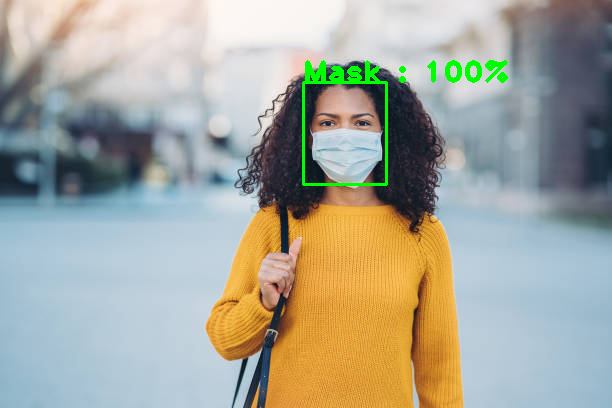

In [12]:
# recognition code
img = cv2.imread('./women_wearing_mask.jpeg')
image = face_mask_prediction(img)
img1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Converting BGR to RGB

display(Image.fromarray(img1))

#plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#plt.show()

In [ ]:
cap = cv2.VideoCapture(0)

while True:
    ret,frames = cap.read()
    if ret == False:
        break
        
    image =   face_mask_prediction(frames) 
    cv2.startWindowThread()
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #plt.show()
    cv2.imshow("facemask",image)
    if cv2.waitKey(1)==27:
        break
cap.release()
cv2.destroyAllWindows()